In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
import json
import os
import imantics
from skimage.transform import resize
import random
from sklearn.model_selection import train_test_split

%matplotlib inline


2024-11-24 17:34:30.261827: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-24 17:34:30.272600: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-24 17:34:30.275841: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-24 17:34:30.283905: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-24 17:34:30.830082: W tensorflow/compiler/tf2

In [3]:
# assign CURRENT_DIR and set paths for annotations and images
CURRENT_DIR = os.getcwd()
annote_dir = f'{CURRENT_DIR}/annotations/instances_default.json'
images_dir = f'{CURRENT_DIR}/images' 

In [4]:
# desired image size
image_size = 512

# input image size 
input_image_size = (1920, 1080)

# image dir
images_listdir = os.listdir(images_dir)

print(f"Dataset contains {len(images_listdir)} images")

Dataset contains 512 images


In [5]:
def read_image(path):
    # Read the image from the specified file path
    img = cv2.imread(path)
    
    # Convert the image from BGR color space (OpenCV default) to RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Resize the image to a specified size (image_size x image_size)
    img = cv2.resize(img, (image_size, image_size))
    
    # Return the processed image
    return img

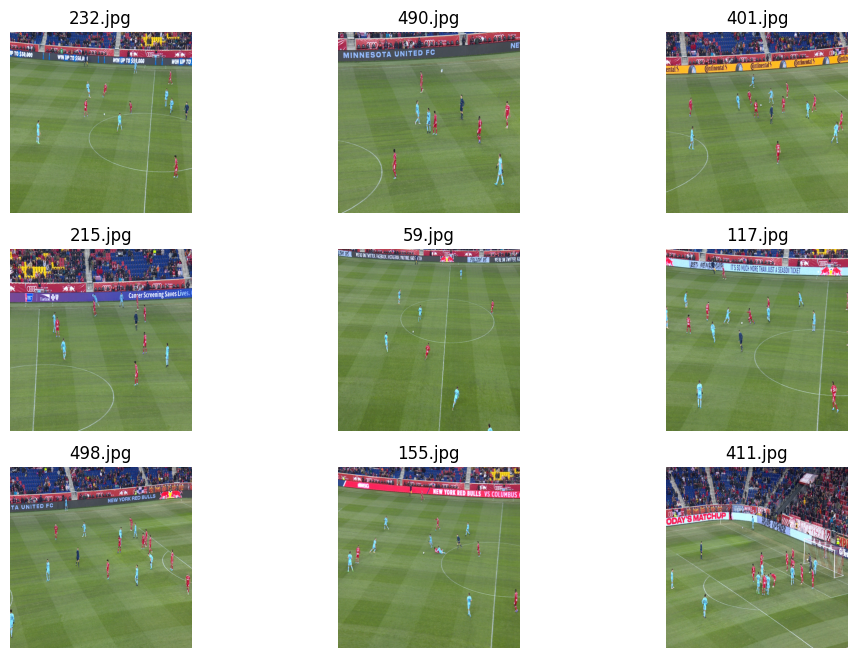

In [6]:
# Select 9 random images from the 'images_listdir' list without replacement
random_images = np.random.choice(images_listdir, size=9, replace=False)

# Set up the grid dimensions for displaying images
rows = 3
cols = 3

# Create a figure with a grid of subplots (3x3) to display images
fig, ax = plt.subplots(rows, cols, figsize=(12, 8))

# Loop through each subplot axis and image index
for i, ax in enumerate(ax.flat):
    # Check if there are more images left to display
    if i < len(random_images):
        # Load and process the selected image using the read_image function
        img = read_image(f"{images_dir}/{random_images[i]}")
        
        # Set the title of the subplot to the image filename
        ax.set_title(f"{random_images[i]}")
        
        # Display the image in the subplot
        ax.imshow(img)
        
        # Turn off the axis display for a cleaner look
        ax.axis('off')

In [7]:
# Load the annotation data from a JSON file specified by 'annote_dir'
annote = json.load(open(annote_dir))

# Create a dictionary that maps each image ID to its corresponding file name
id_to_images = {image['id']: image['file_name'] for image in annote['images']}

# Initialize an empty NumPy array to store all images
# Shape is (number of images, image_size, image_size, 3) with 3 channels for RGB
images = np.zeros((len(images_listdir), image_size, image_size, 3), dtype=np.uint8)

# Loop through each image ID and filename in the dictionary
for image_id, image_filename in id_to_images.items():
    # Load and process the current image using the read_image function
    cur_image = read_image(f"{images_dir}/{image_filename}")
    
    # Store the processed image in the 'images' array, using (image_id - 1) as the index
    images[image_id - 1] = cur_image

# Initialize an empty NumPy array to store masks for each image
# Shape is (number of images, image_size, image_size, 1), with a single channel for mask values
masks = np.zeros((len(images_listdir), image_size, image_size, 1), dtype=bool)

# Loop through each annotation in the JSON file
for annotation in annote["annotations"]:
    # Retrieve the image ID and segmentation data for the current annotation
    image_id = annotation["image_id"]
    segmentation = annotation["segmentation"]
    
    # Convert segmentation polygons into a binary mask array using imantics
    cur_mask = imantics.Polygons(segmentation).mask(*input_image_size).array
    
    # Resize the mask to match the target image size, add a channel dimension
    cur_mask = np.expand_dims(resize(cur_mask, (image_size, image_size), mode='constant', preserve_range=True), 2)
    
    # Determine the mask's index in the 'masks' array using (image_id - 1)
    mask_index = image_id - 1
    
    # Combine the current mask with any existing mask data for the image using a logical OR operation
    masks[mask_index] = masks[mask_index] | cur_mask

# Print out the total number of images and masks loaded
print(f"We have {len(images)} images and {len(masks)} masks")


We have 512 images and 512 masks


In [ ]:
# Split the images and masks into training and test sets
# 'test_size=0.05' means 5% of the data will be used for testing, while 95% will be used for training
# 'random_state=42' ensures the split is reproducible with the same random seed for testing purposes
images_train, images_test, masks_train, masks_test = train_test_split(images, masks, test_size=0.05, random_state=42)
# Print out the shapes of the training and test sets to verify the split
print(f"== Training set shapes == \nImages : {images_train.shape}\nMasks : {masks_train.shape}")
print(f"== Test set shapes == \nImages : {images_test.shape}\nMasks : {masks_test.shape}")

[[[[False]
   [False]
   [False]
   ...
   [False]
   [False]
   [False]]

  [[False]
   [False]
   [False]
   ...
   [False]
   [False]
   [False]]

  [[False]
   [False]
   [False]
   ...
   [False]
   [False]
   [False]]

  ...

  [[False]
   [False]
   [False]
   ...
   [False]
   [False]
   [False]]

  [[False]
   [False]
   [False]
   ...
   [False]
   [False]
   [False]]

  [[False]
   [False]
   [False]
   ...
   [False]
   [False]
   [False]]]


 [[[False]
   [False]
   [False]
   ...
   [False]
   [False]
   [False]]

  [[False]
   [False]
   [False]
   ...
   [False]
   [False]
   [False]]

  [[False]
   [False]
   [False]
   ...
   [False]
   [False]
   [False]]

  ...

  [[False]
   [False]
   [False]
   ...
   [False]
   [False]
   [False]]

  [[False]
   [False]
   [False]
   ...
   [False]
   [False]
   [False]]

  [[False]
   [False]
   [False]
   ...
   [False]
   [False]
   [False]]]


 [[[False]
   [False]
   [False]
   ...
   [False]
   [False]
   [False]]

  [[Fal

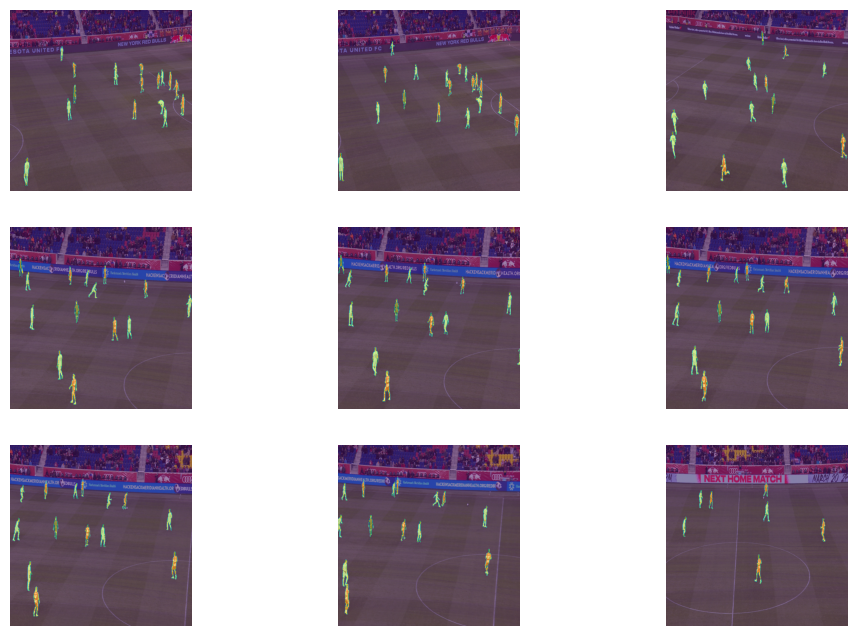

In [ ]:
# Generate a list of 9 random integers between 0 and 511
# Each integer represents an index for randomly selected images and masks
random_numbers = [random.randint(0, 511) for _ in range(9)] 

# Create a figure with a grid of subplots (3x3) to display the images
fig, ax = plt.subplots(rows, cols, figsize=(12, 8))

# Loop through each subplot axis and index in the grid
for i, ax in enumerate(ax.flat):
    # Check if there are more random indices to use for image display
    if i < len(random_numbers):
        # Display the randomly selected image on the subplot
        ax.imshow(images[random_numbers[i]])
        
        # Overlay the corresponding mask with transparency (alpha=0.5) for visual comparison
        ax.imshow(masks[random_numbers[i]], alpha=0.5)
        
        # Turn off the axis display for a cleaner look
        ax.axis('off')


# U-NET TRAINING

In [ ]:
def conv_block(input, num_filters):
    # Apply the first convolutional layer with 'num_filters' filters, a kernel size of 3x3,
    # and 'same' padding to maintain the input dimensions.
    conv = tf.keras.layers.Conv2D(num_filters, 3, padding="same")(input)
    
    # Apply batch normalization to the output of the first convolutional layer.
    # This helps stabilize and accelerate the training process by normalizing the activations.
    conv = tf.keras.layers.BatchNormalization()(conv)
    
    # Apply the ReLU activation function to introduce non-linearity to the model.
    # This allows the model to learn more complex patterns.
    conv = tf.keras.layers.Activation("relu")(conv)
    
    # Apply a second convolutional layer with the same number of filters and parameters as the first.
    conv = tf.keras.layers.Conv2D(num_filters, 3, padding="same")(conv)
    
    # Apply batch normalization again to the output of the second convolutional layer.
    conv = tf.keras.layers.BatchNormalization()(conv)
    
    # Apply the ReLU activation function to the output of the second convolutional layer.
    conv = tf.keras.layers.Activation("relu")(conv)
    
    # Return the output of the convolutional block, which is the result of two convolutional layers
    # followed by batch normalization and activation.
    return conv

In [ ]:
def encoder_block(input, num_filters):
    # Pass the input through a convolutional block to extract features
    # and perform operations such as convolution, batch normalization, and activation.
    skip = conv_block(input, num_filters)
    
    # Apply max pooling to the output of the convolutional block.
    # This reduces the spatial dimensions by a factor of 2 (downsampling),
    # which helps to capture the most important features while reducing computation.
    pool = tf.keras.layers.MaxPool2D((2, 2))(skip)
    
    # Return two outputs:
    # 1. 'skip': the output of the convolutional block (for potential use in skip connections).
    # 2. 'pool': the downsampled feature map after max pooling.
    return skip, pool

In [ ]:
def decoder_block(input, skip, num_filters):
    # Apply a transposed convolution (also known as deconvolution) to upsample the input feature map.
    # This operation uses 'num_filters' filters with a kernel size of 2x2 and a stride of 2 to double the spatial dimensions.
    up_conv = tf.keras.layers.Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    
    # Concatenate the upsampled feature map with the corresponding feature map from the encoder block.
    # This allows the model to retain high-resolution features while reconstructing the image.
    conv = tf.keras.layers.Concatenate()([up_conv, skip])
    
    # Pass the concatenated feature map through a convolutional block to refine the features.
    # The 'conv_block' function performs convolution, batch normalization, and activation.
    conv = conv_block(conv, num_filters)
    
    # Return the refined feature map after processing through the convolutional block.
    return conv

In [ ]:
def Unet(input_shape):
    # Define the input layer with the specified input shape
    inputs = tf.keras.layers.Input(input_shape)

    # Encoder path: Create the encoder blocks of size 64, 128, 256, 512 and capture skip connections
    skip1, pool1 = encoder_block(inputs, 64)  
    skip2, pool2 = encoder_block(pool1, 128)  
    skip3, pool3 = encoder_block(pool2, 256)  
    skip4, pool4 = encoder_block(pool3, 512)  

    # Bridge: Apply a convolutional block on the deepest layer (pool4) to capture high-level features
    bridge = conv_block(pool4, 1024)

    # Decoder path: Create the decoder blocks with size 512, 256, 128, 64, 
    # incorporating skip connections for better feature reconstruction
    decode1 = decoder_block(bridge, skip4, 512) 
    decode2 = decoder_block(decode1, skip3, 256)
    decode3 = decoder_block(decode2, skip2, 128)
    decode4 = decoder_block(decode3, skip1, 64) 

    # Output layer: Apply a 1x1 convolution to produce the final output segmentation map with a single channel
    # The 'sigmoid' activation function is used for binary segmentation tasks
    outputs = tf.keras.layers.Conv2D(1, 1, padding="same", activation="sigmoid")(decode4)

    # Create the Keras model object using the defined inputs and outputs
    model = tf.keras.models.Model(inputs, outputs, name="U-Net")
    
    # Return the constructed U-Net model
    return model

In [ ]:
# create unet model, with 512 representing height and width of image, 3 representing RGB colour channels
unet_model = Unet((512, 512, 3))

# compile UNET model using the adam optmiser, binary_crossentropy loss function,
# with the evaluation of accuraccy for calcuating correctly classifeid pixels. 
unet_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# display a UNET model summary 
unet_model.summary()

In [ ]:
# train UNET model using images and masks, with a 20% validation set for 5 epochs with a batch size of 4
unet_result = unet_model.fit(images_train, masks_train, validation_split = -1.2, batch_size = 4, epochs = 5)

Epoch 1/5


2024-11-03 17:52:59.488143: W external/local_tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 32.55GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-11-03 17:53:00.105038: W external/local_tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 16.53GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-11-03 17:53:01.098674: W external/local_tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 33.03GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-11-03 17:53:02.135224: W external/local_tsl/tsl/framework/b

97/97 ━━━━━━━━━━━━━━━━━━━━ 94s 593ms/step - accuracy: 0.9417 - loss: 0.2388 - val_accuracy: 0.0617 - val_loss: 5.6411
Epoch 2/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 57s 585ms/step - accuracy: 0.9959 - loss: 0.0351 - val_accuracy: 0.9941 - val_loss: 0.0385
Epoch 3/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 57s 589ms/step - accuracy: 0.9971 - loss: 0.0184 - val_accuracy: 0.9966 - val_loss: 0.0176
Epoch 4/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 57s 592ms/step - accuracy: 0.9976 - loss: 0.0120 - val_accuracy: 0.9973 - val_loss: 0.0119
Epoch 5/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 58s 594ms/step - accuracy: 0.9977 - loss: 0.0097 - val_accuracy: 0.9973 - val_loss: 0.0097


# U²-NET TRAINING

In [ ]:
def conv_block(shape, out_ch, rate=1):
    # Apply a 3x3 Conv2D layer with 'out_ch' filters, keeping output dimensions the same as input.
    # The 'dilation_rate' parameter allows for optional dilated convolutions.
    x = tf.keras.layers.Conv2D(out_ch, 3, padding="same", dilation_rate=rate)(shape)
    
    # BatchNormalize the output of the convolutional layer to stabilize and accelerate training..
    x = tf.keras.layers.BatchNormalization()(x)
    
    # ReLU sets all negative values to zero, allowing positive values to pass through unchanged.
    x = tf.keras.layers.Activation("relu")(x)
    
    # Return the processed conv_block
    return x


In [ ]:
def RSU_L(shape, out_ch, M_ch, num_layers, rate=2):
    # Initial convolutional layer to process input with 'out_ch' filters
    x = conv_block(shape, out_ch)
    inp_ch = x  # Store initial processed input for later addition

    # Initialize a list to store skip connections
    skip_features = []
    
    # First convolution and store in skip connections
    x = conv_block(x, M_ch)
    skip_features.append(x)

    # Downsampling path: Perform convolution after max pooling, and store each output in skip_features
    for i in range(num_layers-2):
        x = tf.keras.layers.MaxPool2D((2, 2))(x)  # Downsample by 2
        x = conv_block(x, M_ch)
        skip_features.append(x)

    # Apply a convolution with dilation rate in the deepest layer
    x = conv_block(x, M_ch, rate=rate)

    # Reverse skip connections for the upsampling path
    skip_features.reverse()

    # Begin upsampling, adding skip features, and processing with convolutional blocks
    x = tf.keras.layers.Concatenate()([x, skip_features[0]])
    x = conv_block(x, M_ch)

    for i in range(num_layers-3):
        x = tf.keras.layers.UpSampling2D(size=(2, 2), interpolation="bilinear")(x)  # Upsample by 2
        x = tf.keras.layers.Concatenate()([x, skip_features[i+1]])  # Add corresponding skip connection
        x = conv_block(x, M_ch)

    # Final upsampling and concatenation with the outermost skip connection
    x = tf.keras.layers.UpSampling2D(size=(2, 2), interpolation="bilinear")(x)
    x = tf.keras.layers.Concatenate()([x, skip_features[-1]])
    x = conv_block(x, out_ch)

    # Add the processed input and final output for residual learning
    x = tf.keras.layers.Add()([x, inp_ch])
    return x

In [ ]:
def RSU_4F(shape, out_ch, M_ch):
    # Initial convolution with 'out_ch' filters and no dilation (rate=1)
    x0 = conv_block(shape, out_ch, rate=1)

    # Apply a series of convolutions with increasing dilation rates
    x1 = conv_block(x0, M_ch, rate=1)   # First layer with dilation rate 1
    x2 = conv_block(x1, M_ch, rate=2)   # Second layer with dilation rate 2
    x3 = conv_block(x2, M_ch, rate=4)   # Third layer with dilation rate 4

    # Deepest convolution with the highest dilation rate (rate=8)
    x4 = conv_block(x3, M_ch, rate=8)

    # Begin the upsampling path, progressively reducing the dilation rate
    x = tf.keras.layers.Concatenate()([x4, x3])  # Concatenate with x3 (skip connection)
    x = conv_block(x, M_ch, rate=4)

    # Concatenate with x2 and apply a convolution with a reduced dilation rate
    x = tf.keras.layers.Concatenate()([x, x2])
    x = conv_block(x, M_ch, rate=2)

    # Concatenate with x1 and apply a convolution with no dilation (rate=1)
    x = tf.keras.layers.Concatenate()([x, x1])
    x = conv_block(x, out_ch, rate=1)

    # Add the initial layer output (x0) to the final output for residual learning
    x = tf.keras.layers.Add()([x, x0])
    return x

In [ ]:
def u2net(shape, out_ch, M_ch, num_classes=1):
    # Define input layer with specified shape
    inputs = tf.keras.layers.Input(shape)

    # Encoder (Downsampling) Path: Each encoder block captures features at different resolutions
    e1 = RSU_L(inputs, out_ch[0], M_ch[0], 7)
    p1 = tf.keras.layers.MaxPool2D((2, 2))(e1)  # Downsample by a factor of 2

    e2 = RSU_L(p1, out_ch[1], M_ch[1], 6)
    p2 = tf.keras.layers.MaxPool2D((2, 2))(e2)

    e3 = RSU_L(p2, out_ch[2], M_ch[2], 5)
    p3 = tf.keras.layers.MaxPool2D((2, 2))(e3)

    e4 = RSU_L(p3, out_ch[3], M_ch[3], 4)
    p4 = tf.keras.layers.MaxPool2D((2, 2))(e4)

    # Bottleneck layer: Further downsampling without pooling
    e5 = RSU_4F(p4, out_ch[4], M_ch[4])
    p5 = tf.keras.layers.MaxPool2D((2, 2))(e5)

    # Bridge layer: The deepest part of the network
    b1 = RSU_4F(p5, out_ch[5], M_ch[5])
    b2 = tf.keras.layers.UpSampling2D(size=(2, 2), interpolation="bilinear")(b1)

    # Decoder (Upsampling) Path: Restore resolution with skip connections from the encoder
    d1 = tf.keras.layers.Concatenate()([b2, e5])
    d1 = RSU_4F(d1, out_ch[6], M_ch[6])
    u1 = tf.keras.layers.UpSampling2D(size=(2, 2), interpolation="bilinear")(d1)

    d2 = tf.keras.layers.Concatenate()([u1, e4])
    d2 = RSU_L(d2, out_ch[7], M_ch[7], 4)
    u2 = tf.keras.layers.UpSampling2D(size=(2, 2), interpolation="bilinear")(d2)

    d3 = tf.keras.layers.Concatenate()([u2, e3])
    d3 = RSU_L(d3, out_ch[8], M_ch[8], 5)
    u3 = tf.keras.layers.UpSampling2D(size=(2, 2), interpolation="bilinear")(d3)

    d4 = tf.keras.layers.Concatenate()([u3, e2])
    d4 = RSU_L(d4, out_ch[9], M_ch[9], 6)
    u4 = tf.keras.layers.UpSampling2D(size=(2, 2), interpolation="bilinear")(d4)

    d5 = tf.keras.layers.Concatenate()([u4, e1])
    d5 = RSU_L(d5, out_ch[10], M_ch[10], 7)

    # Output Layers: Generate multiple feature maps (y1 - y6) at different resolutions
    y1 = tf.keras.layers.Conv2D(num_classes, 3, padding="same")(d5)

    y2 = tf.keras.layers.Conv2D(num_classes, 3, padding="same")(d4)
    y2 = tf.keras.layers.UpSampling2D(size=(2, 2), interpolation="bilinear")(y2)

    y3 = tf.keras.layers.Conv2D(num_classes, 3, padding="same")(d3)
    y3 = tf.keras.layers.UpSampling2D(size=(4, 4), interpolation="bilinear")(y3)

    y4 = tf.keras.layers.Conv2D(num_classes, 3, padding="same")(d2)
    y4 = tf.keras.layers.UpSampling2D(size=(8, 8), interpolation="bilinear")(y4)

    y5 = tf.keras.layers.Conv2D(num_classes, 3, padding="same")(d1)
    y5 = tf.keras.layers.UpSampling2D(size=(16, 16), interpolation="bilinear")(y5)

    y6 = tf.keras.layers.Conv2D(num_classes, 3, padding="same")(b1)
    y6 = tf.keras.layers.UpSampling2D(size=(32, 32), interpolation="bilinear")(y6)

    # Final output: Concatenate all feature maps (y1 - y6) and apply one final convolution
    y0 = tf.keras.layers.Concatenate()([y1, y2, y3, y4, y5, y6])
    y0 = tf.keras.layers.Conv2D(num_classes, 3, padding="same")(y0)

    # Sigmoid activation for final outputs (binary segmentation)
    y0 = tf.keras.layers.Activation("sigmoid")(y0)
    y1 = tf.keras.layers.Activation("sigmoid")(y1)
    y2 = tf.keras.layers.Activation("sigmoid")(y2)
    y3 = tf.keras.layers.Activation("sigmoid")(y3)
    y4 = tf.keras.layers.Activation("sigmoid")(y4)
    y5 = tf.keras.layers.Activation("sigmoid")(y5)
    y6 = tf.keras.layers.Activation("sigmoid")(y6)

    # Define and return the U2-Net model
    model = tf.keras.models.Model(inputs, outputs=y0, name="U2-Net")
    return model


In [ ]:
def build_u2net(input_shape, num_classes=1):
    # Define the number of output channels for each layer in the network
    out_ch = [64, 128, 256, 512, 512, 512, 512, 256, 128, 64, 64]
    
    # Define the number of middle channels for each layer in the network
    M_ch = [32, 32, 64, 128, 256, 256, 256, 128, 64, 32, 16]
    
    # Build the U2-Net model with specified input shape, output channels, middle channels, and classes
    model = u2net(input_shape, out_ch, M_ch, num_classes=num_classes)
    
    # Return the constructed U2-Net model
    return model

In [ ]:
def build_u2net_lite(input_shape, num_classes=1):
    # Define reduced output channels for each layer to create a lighter version of U2-Net
    out_ch = [64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64]
    
    # Define reduced middle channels for each layer, keeping it consistent across layers
    M_ch = [16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16]
    
    # Build a lightweight U2-Net model with specified input shape and number of classes
    model = u2net(input_shape, out_ch, M_ch, num_classes=num_classes)
    
    # Return the lightweight U2-Net model
    return model

In [ ]:
# Build the U2-Net model with the specified input shape (512 x 512 with 3 color channels for RGB)
u2net_model = build_u2net((image_size, image_size, 3))

# Compile the model with the Adam optimizer, binary cross-entropy loss, and accuracy metric
u2net_model.compile(optimizer="adam", loss='binary_crossentropy', metrics=['accuracy'])

# print a summary of the model's architecture 
u2net_model.summary()

I0000 00:00:1730654798.499200    5343 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730654798.530855    5343 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730654798.531038    5343 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730654798.531738    5343 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

In [ ]:
# Build the lightweight version of the U2-Net model with specified input shape (512 x 512 with 3 color channels for RGB)
u2netlite_model = build_u2net_lite((image_size, image_size, 3))

# Compile the model with the Adam optimizer, binary cross-entropy loss, and accuracy metric
u2netlite_model.compile(optimizer="adam", loss='binary_crossentropy', metrics=['accuracy'])

# print a summary of the model's architecture 
u2netlite_model.summary()

# U2net training 

In [ ]:
# train U2NET model using images and masks, with a 20% validation set for 5 epochs with a batch size of 4
u2net_result = u2net_model.fit(images_train, masks_train, validation_split = 0.2, batch_size = 4, epochs = 5)

Epoch 1/5


I0000 00:00:1730654830.590893    5485 service.cc:146] XLA service 0x7feaa8001380 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1730654830.590915    5485 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2024-11-03 17:27:11.655593: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-11-03 17:27:15.251114: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
2024-11-03 17:27:41.056587: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[4,128,512,512]{3,2,1,0}, u8[0]{0}) custom-call(f32[4,64,512,512]{3,2,1,0}, f32[64,128,3,3]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardInput", backend_config={"operation_queue_id":"0","wait_on_operation_qu

97/97 ━━━━━━━━━━━━━━━━━━━━ 216s 874ms/step - accuracy: 0.9786 - loss: 0.0679 - val_accuracy: 0.9791 - val_loss: 920.5820
Epoch 2/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 71s 729ms/step - accuracy: 0.9969 - loss: 0.0081 - val_accuracy: 0.9959 - val_loss: 0.0250
Epoch 3/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 70s 724ms/step - accuracy: 0.9975 - loss: 0.0065 - val_accuracy: 0.9973 - val_loss: 0.0069
Epoch 4/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 69s 715ms/step - accuracy: 0.9977 - loss: 0.0058 - val_accuracy: 0.9974 - val_loss: 0.0067
Epoch 5/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 69s 713ms/step - accuracy: 0.9977 - loss: 0.0059 - val_accuracy: 0.9978 - val_loss: 0.0055


# U2net-lite training

In [ ]:
# train U2NET-LITE model using images and masks, with a 20% validation set for 5 epochs with a batch size of 4
u2netlite_result = u2netlite_model.fit(images_train, masks_train, validation_split = 0.2, batch_size = 4, epochs = 5)

Epoch 1/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 105s 459ms/step - accuracy: 0.9473 - loss: 0.1141 - val_accuracy: 0.9851 - val_loss: 0.0760
Epoch 2/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 38s 393ms/step - accuracy: 0.9965 - loss: 0.0093 - val_accuracy: 0.9945 - val_loss: 0.0149
Epoch 3/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 38s 395ms/step - accuracy: 0.9974 - loss: 0.0067 - val_accuracy: 0.9971 - val_loss: 0.0074
Epoch 4/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 38s 396ms/step - accuracy: 0.9977 - loss: 0.0059 - val_accuracy: 0.9976 - val_loss: 0.0059
Epoch 5/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 38s 395ms/step - accuracy: 0.9978 - loss: 0.0054 - val_accuracy: 0.9975 - val_loss: 0.0062


# Test Models

## UNET testing

In [ ]:
# Make predictions on the test images using the U-Net model
# - 'images_test' is the test dataset
# - 'batch_size=4' means processing 4 images at a time
unet_predict = unet_model.predict(images_test, batch_size=4)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 171ms/step


In [ ]:
# Convert UNET predictions to binary (1 for player/referee detected, 0 if not) using >= 0.5 as threshold
unet_predict = (unet_predict >= 0.5).astype(np.uint8)

## U2NET testing

In [ ]:
# Make predictions on the test images using the U2-Net model
# - 'images_test' is the test dataset
# - 'batch_size=4' means processing 4 images at a time
u2net_predict = u2net_model.predict(images_test, batch_size = 4)

7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 773ms/step


In [ ]:
# Convert U2NET predictions to binary (1 for player/referee detected, 0 if not) using >= 0.5 as threshold
u2net_predict = (u2net_predict >= 0.5).astype(np.uint8)

## U2NET-LITE TESTING

In [ ]:
# Make predictions on the test images using the U2-Net-Lite model
# - 'images_test' is the test dataset
# - 'batch_size=4' means processing 4 images at a time
u2netlite_predict = u2netlite_model.predict(images_test, batch_size = 4)

7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 631ms/step


In [ ]:
# Convert U2NET-LITE predictions to binary (1 for player/referee detected, 0 if not) using >= 0.5 as threshold
u2netlite_predict = (u2netlite_predict >= 0.5).astype(np.uint8)

# Displaying Results

In [ ]:
# Function to display and compare results from different models
def show_result(og, unet, u2net, u2netlite, target):
    # Create a figure with 5 side-by-side subplots, each showing a different image
    _, axs = plt.subplots(1, 5, figsize=(20, 10))

    # Display the original image in the first subplot
    axs[0].set_title("Original")
    axs[0].imshow(og)
    axs[0].axis('off')  # Hide axis lines and labels

    # Display U-Net model's output in the second subplot
    axs[1].set_title("U-Net")
    axs[1].imshow(unet)
    axs[1].axis('off')

    # Display U2-Net model's output in the third subplot
    axs[2].set_title("U2-Net")
    axs[2].imshow(u2net)
    axs[2].axis('off')

    # Display U2-Net-Lite model's output in the fourth subplot
    axs[3].set_title("U2-Net-Lite")
    axs[3].imshow(u2netlite)
    axs[3].axis('off')

    # Display the true label in the fifth subplot
    axs[4].set_title("True Label (Human)")
    axs[4].imshow(target)
    axs[4].axis('off')

    # Show the entire figure
    plt.show()

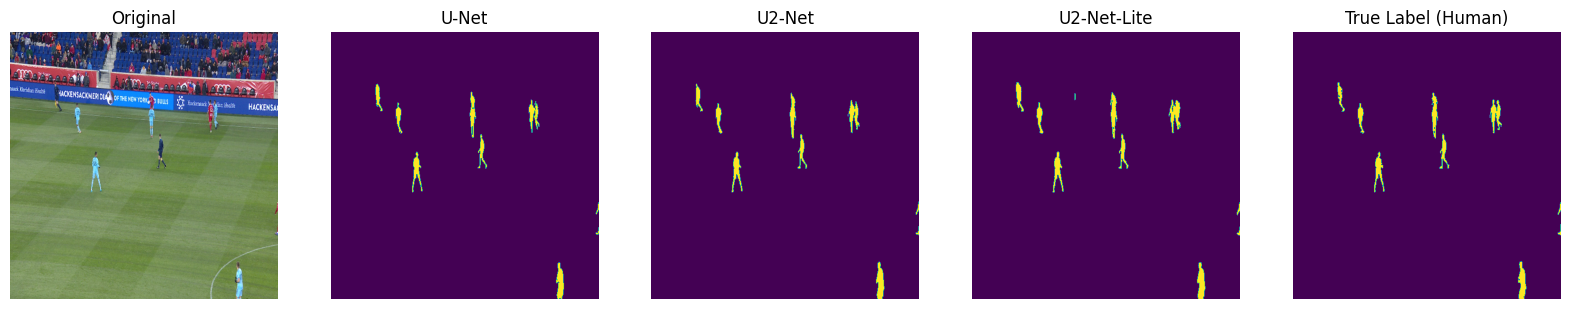

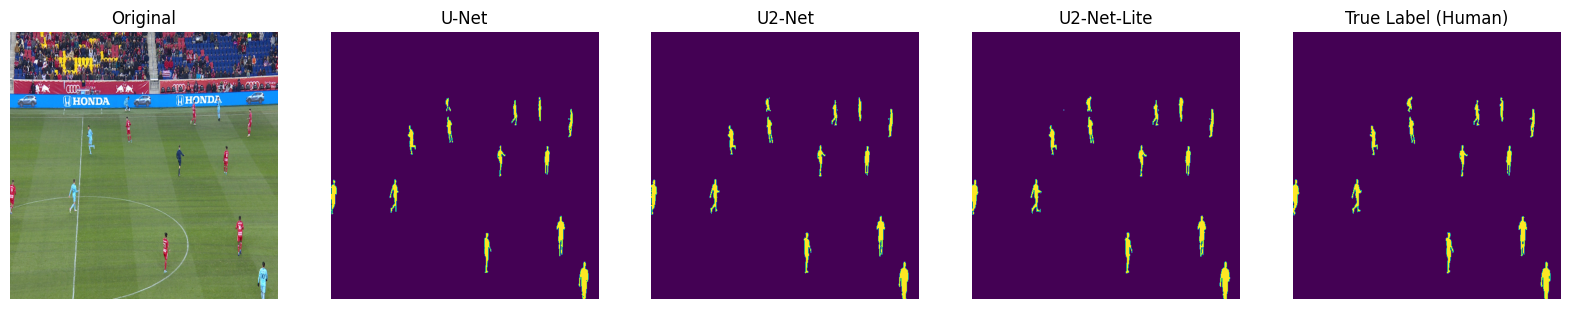

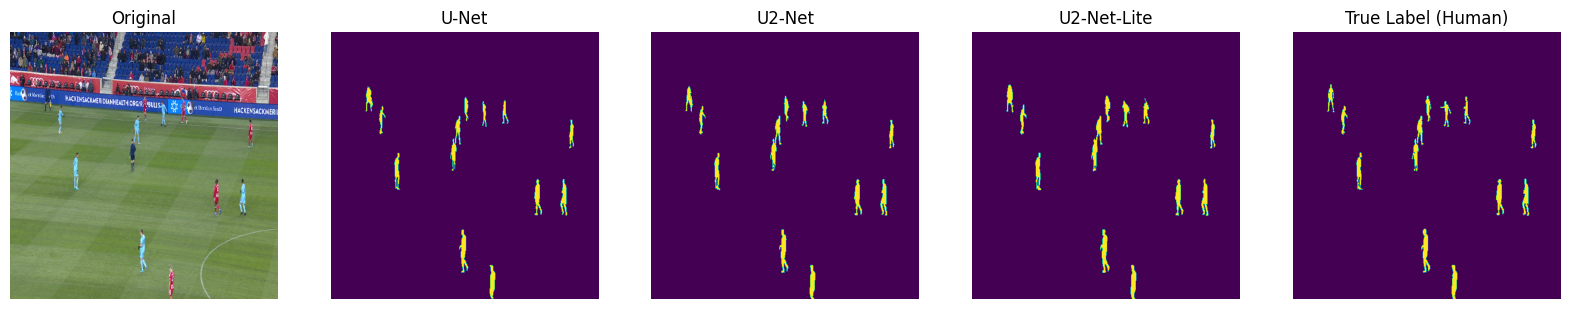

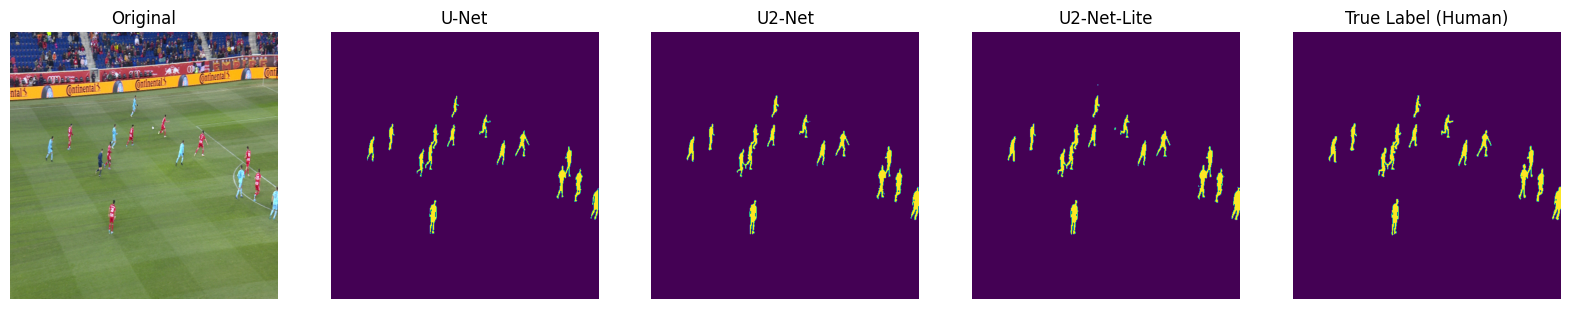

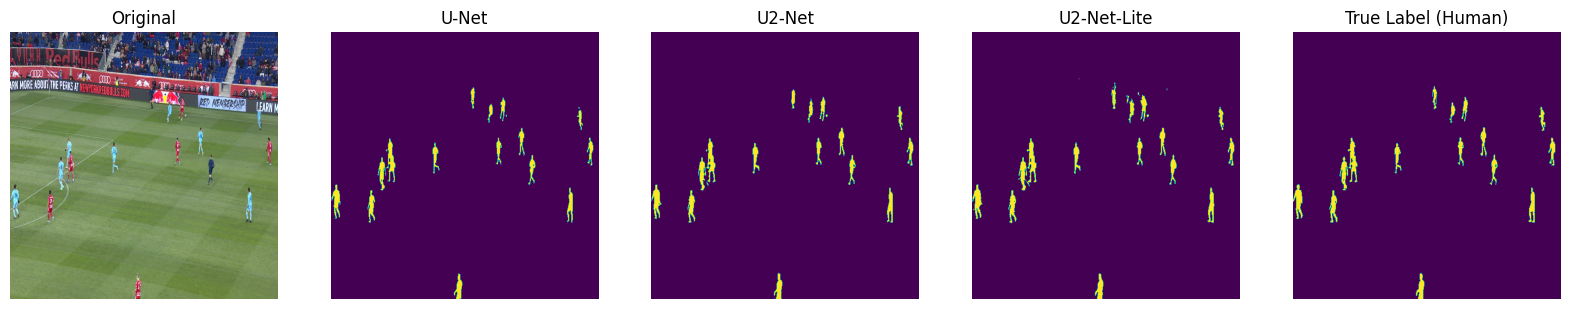

In [ ]:
# Randomly select 3 indices from the test set range (0 to 25)
show_test_idx = random.sample(range(26), 3)

# Loop through the selected indices to display model results for each chosen test image, 
# showing (Original, UNET Prediction, U2NET Prediction, U2NET-LITE Prediction, True Label (Human))
for idx in show_test_idx:  
    show_result(images_test[idx], unet_predict[idx], u2net_predict[idx], u2netlite_predict[idx], masks_test[idx])